# Lab 4: Transform coding

This lab aims to get familiar with transform coding methods based on the DFT and DCT transforms.

## Reference concepts

### Transform coding
It refers to the techniques used in signal compression that convert a signal from its original domain (such as the time domain or spatial domain) into a different domain, typically the frequency domain, where the signal can be represented more efficiently. The goal of transform coding is to reduce the amount of data required to represent the signal by taking advantage of redundancies or perceptual irrelevancies.

### Discrete Fourier Transform (DFT)
The DFT is the basic frequency-domain transformation, conceptually easy to understand, and suitable for most kind of spectral analysis and spectral transformations. However, the STFT, built on top of the DFT, requires overlapping between windows, but it doubles the information that need to be stored: not very good for compression.

### Discrete Cosine Transform (DCT)
The DCT is a transform similar to the DFT but using only real numbers. It expresses a finite sequence of data points in terms of a sum of cosine functions oscillating at different frequencies. The DCT is widely used in applications such as audio, image, and video compression due to its ability to concentrate energy in a small number of coefficients.

### Modified Discrete Cosine Transform (MDCT)
The MDCT is an extension of the DCT, designed specifically for audio compression algorithms such as MP3 or AAC. The MDCT helps to reduce blocking artifacts and efficiently compress overlapping blocks of data, which is particularly important for perceptual audio coding.


In [1]:
import scipy.signal as signal
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, dct, idct
from scipy.io.wavfile import read
import IPython.display as ipd

In [2]:
# functions used in the whole lab
def read_sound(file):
  """ read a mono wav sound file, assuming is mono, and convert it to a floating point array
    Args:
      file (str): File name
    Returns:
      sound_array (numpy.array): Array of samples as floating point values between -1 and 1
      sampling_rate (int): Sampling rate
  """
  # read sound file
  sampling_rate, x = read(file)
  # convert to floating point values between -1 and 1, assuming x are 16 bit integers
  sound_array = np.float32(x) / 2**15
  return sound_array, sampling_rate

def display_sound(sound_array, sampling_rate=44100):
  """ Display signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      sampling_rate (int): Sampling rate
  """
  # plot the waveform of the sound
  plt.figure(0, figsize=(10, 2))
  time_indexes = np.arange(0, sound_array.size/sampling_rate, 1.0/sampling_rate)
  plt.plot(time_indexes, sound_array)
  plt.xlabel('time (seconds)')
  plt.ylabel('amplitude')
  plt.show()
  # play the sound
  ipd.display(ipd.Audio(data=sound_array, rate=sampling_rate))

## Part 1 - DFT, DCT

Compare the DFT with the DCT. Answer the questions given while modifying the code as needed to support the answers.

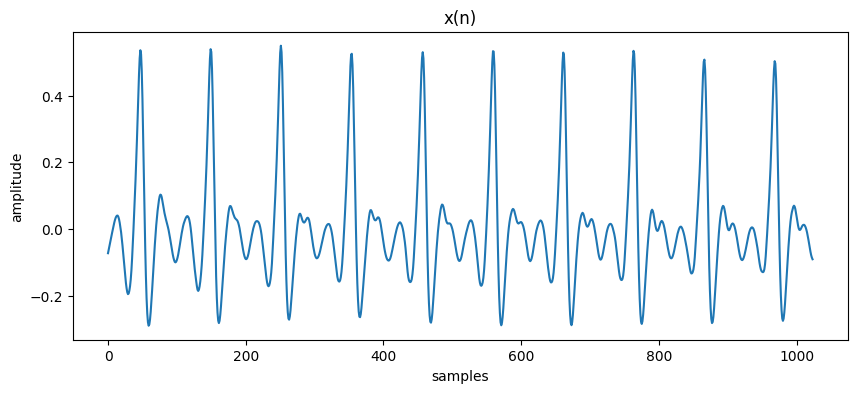

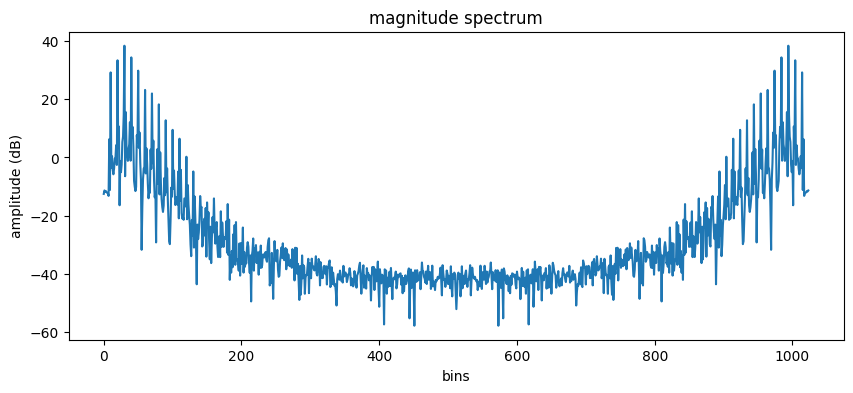

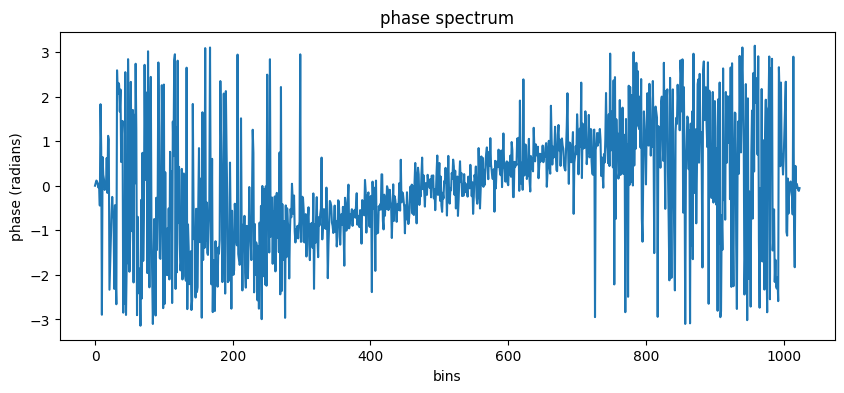

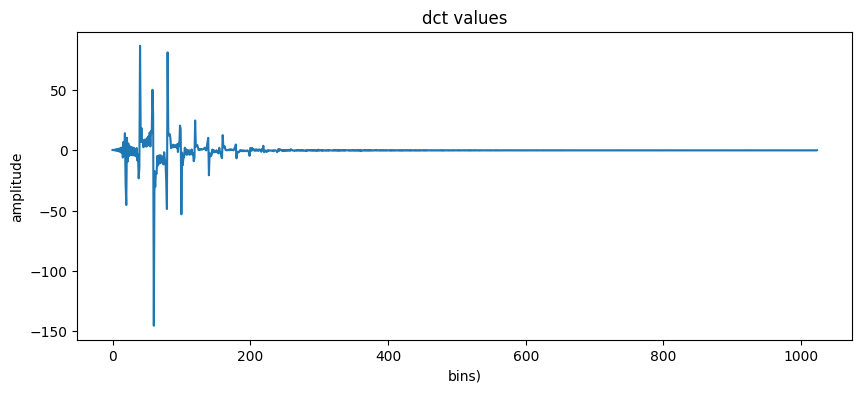

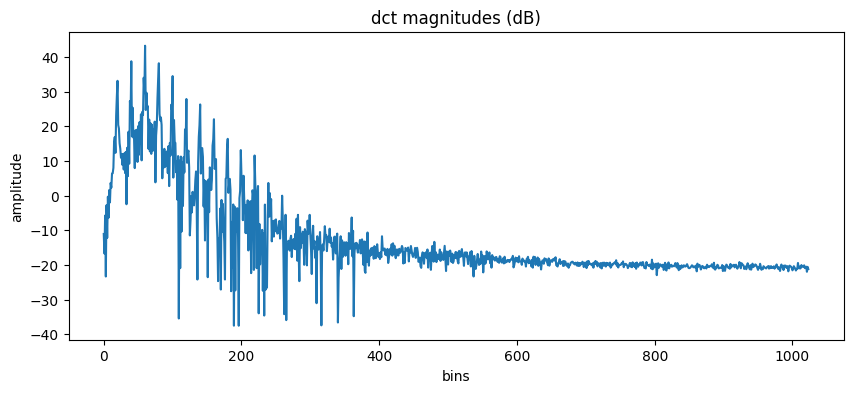

In [3]:
# perform dft and dct of a sinewave

x, fs = read_sound('../sounds/487465-trumpet.wav')
N = 1024
xf = x[2000:2000+N]

plt.figure(1, figsize=(10, 4))
plt.plot(xf)
plt.xlabel('samples')
plt.ylabel('amplitude')
plt.title('x(n)')
plt.show()

X_dft = fft(xf)
plt.figure(1, figsize=(10, 4))
plt.plot(20*np.log10(np.abs(X_dft)))
plt.xlabel('bins')
#plt.xlim(0,100)
plt.ylabel('amplitude (dB)')
plt.title('magnitude spectrum')
plt.show()

X_dft = fft(xf)
plt.figure(1, figsize=(10, 4))
plt.plot(np.angle(X_dft))
plt.xlabel('bins')
plt.ylabel('phase (radians)')
plt.title('phase spectrum')
plt.show()

X_dct = dct(xf, type=4)
plt.figure(0, figsize=(10, 4))
plt.plot(X_dct)
plt.xlabel('bins)')
plt.ylabel('amplitude')

plt.title('dct values')
plt.show()

plt.figure(0, figsize=(10, 4))
plt.plot(20*np.log10(np.abs(X_dct)))
plt.xlabel('bins')
#plt.xlim(50,75)
plt.ylabel('amplitude')
plt.title('dct magnitudes (dB)')
plt.show()

**Questions:**

1. Compute the DFT and the DCT of a sinewave and describe the similarities and differences of the outputs obtained. Find the location of the peak in the magnitudes of both spectra. What is the difference.

The DFT (Discrete Fourier Transform) is commonly used for frequency-domain analysis and transformations. It captures both positive and negative frequencies, resulting in a symmetric spectrum. However, the DFT requires overlapping between windows and stores both real and imaginary components, making it less efficient for compression purposes.

The DCT (Discrete Cosine Transform), on the other hand, produces a real-valued spectrum, focusing only on the positive frequencies. This makes it more efficient for compression, as it reduces the amount of data to be stored. The DCT provides twice as many frequency values for the same number of time-domain samples.

As seen in the plot:

The DFT produces symmetric peaks, with the peak in the magnitude occurring at index 10. The DCT shows two pics at index 19 and 21, which corresponds to twice the frequency of the DFT peak. 

2. Compute the DFT and DCT of a complex sound (one of the sounds in the sounds directory), and compare and describe their spectrum.


For the trumpet sound, the DFT results in a more complex spectrum due to the rich harmonic content of the sound. Despite this complexity, the symmetric nature of the DFT is still present, with a prominent peak at index 30.

For the DCT, the spectrum follows a similar shape to that of the sine wave but shows more peaks and noise, reflecting the higher frequency components and the overall complexity of the sound. The main peak is observed at index 60, which is twice the frequency of the DFT peak.l.


____

## Part 2 - STFT, MCDT

Compute and compare a coding/decoding system using both the STFT and the MDCT. Answer the questions given while modifying the code as needed to support the answers.

In [4]:
# functions needed to compute mdct

N = 1024

#The D(z) matrix:
def Dmatrix(samples):
    #implementation of the delay matrix D(z)
    N = len(samples)
    out=np.zeros(N)
    out[0:int(N/2)]=Dmatrix.z
    Dmatrix.z=samples[0:int(N/2)]
    out[int(N/2):N]=samples[int(N/2):N]
    return out

Dmatrix.z=np.zeros(N//2)

#The inverse D(z) matrix:
def Dmatrixinv(samples):
    #implementation of the delay matrix D(z)
    N = len(samples)
    out=np.zeros(N)
    out[int(N/2):N]=Dmatrixinv.z
    Dmatrixinv.z=samples[int(N/2):N]
    out[0:int(N/2)]=samples[0:int(N/2)]
    return out

Dmatrixinv.z=np.zeros(int(N/2))

#The F Matrix:
fcoeff=np.sin(np.pi/(2*N)*(np.arange(0,2*N)+0.5))
Fmatrix=np.zeros((N,N))
Fmatrix[0:int(N/2),0:int(N/2)]=np.fliplr(np.diag(fcoeff[0:int(N/2)]))
Fmatrix[int(N/2):N,0:int(N/2)]=np.diag(fcoeff[int(N/2):N])
Fmatrix[0:int(N/2),int(N/2):N]=np.diag(fcoeff[N:int(N+N/2)])
Fmatrix[int(N/2):N,int(N/2):N]=-np.fliplr(np.diag(fcoeff[int(N+N/2):(2*N)]))

#The inverse F matrix:
Finv=np.linalg.inv(Fmatrix)

#The complete MDCT, Analysis:
def MDCT(samples):
    y=np.dot(samples,Fmatrix)
    y=Dmatrix(y)
    y=dct(y,type=4)
    return y

#The inverse MDCT, synthesis:
def MDCTinv(y):
    #inverse DCT4 is identical to DCT4:
    x=idct(y,type=4)/(2*len(y))
    #inverse D(z) matrix
    x=Dmatrixinv(x)
    #inverse F matrix
    x=np.dot(x,Finv)
    return x

def display_spectrogram_mcdt(x, N, fs=44100):
  i = 0
  Xf = []
  while i < x.size-N:
    X = MDCT(x[i:i+N])
    Xf.append(np.array(X))
    i += N

  Xf = np.array(Xf)
  plt.figure(figsize=(10, 5))
  plt.pcolormesh(np.transpose(20*np.log10(np.abs(Xf))), shading='auto', cmap='inferno')
  plt.colorbar(format='%+2.0f dB')
  plt.xlabel('frames')
  plt.ylabel('bins')
  plt.show()

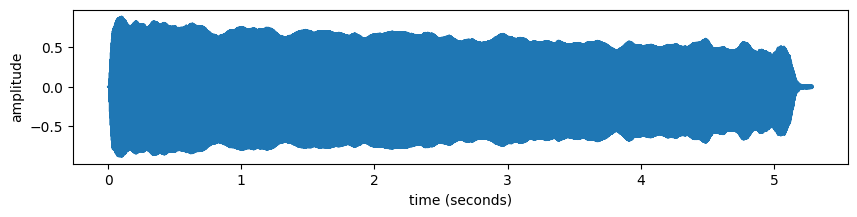

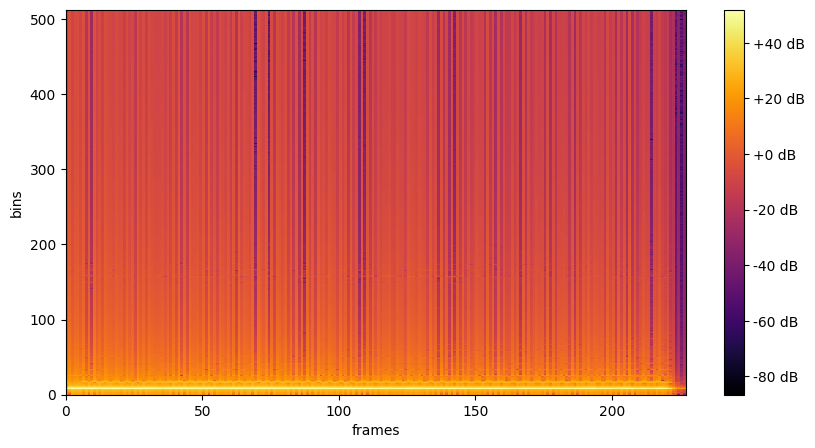

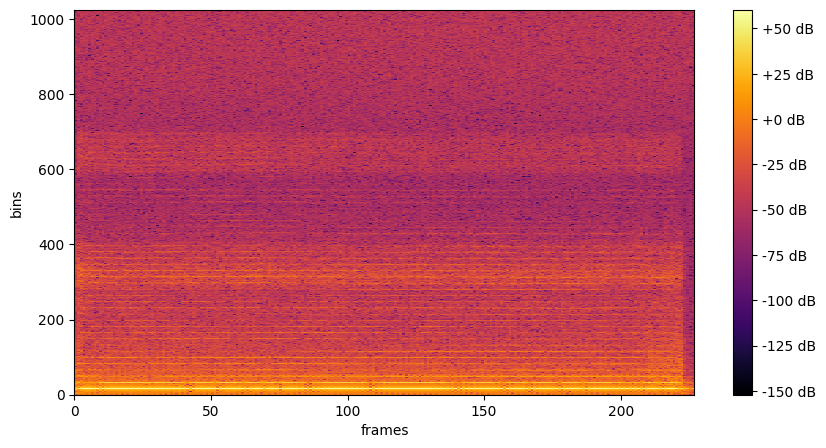

In [8]:
# compute the spectrogram of a sound using both the STFT and the MDCT

def display_spectrogram_stft(sound_array, fft_size=512, sampling_rate=44100):
  # initialize the output spectrogram
  magnitude_spectrogram = []
  sample_index = 0
  # iterate over the input sound computing a sequence of spectra
  while sample_index < sound_array.size-fft_size:
    spectrum = fft(sound_array[sample_index:sample_index+fft_size])
    magnitude_spectrum = 20*np.log10(abs(spectrum[:spectrum.size//2]))
    magnitude_spectrogram.append(magnitude_spectrum)
    sample_index += fft_size

  # plot the magnitude sspectrogram
  plt.figure(figsize=(10, 5))
  plt.pcolormesh(np.transpose(magnitude_spectrogram), shading='auto', cmap='inferno')
  plt.colorbar(format='%+2.0f dB')
  plt.xlabel('frames')
  plt.ylabel('bins')
  plt.show()

x, fs = read_sound('../sounds/406609-tuba.wav')
display_sound(x, fs)

display_spectrogram_stft(x, N, 1)

display_spectrogram_mcdt(x, N, fs)

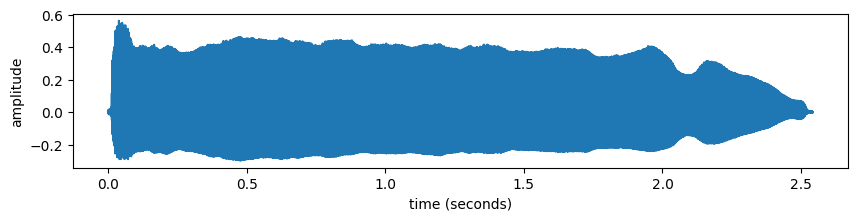

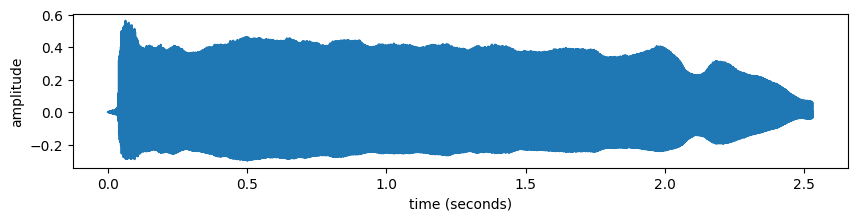

In [6]:
# perform MCDT and inverse MCDT

def compute_mcdt(x, N, fs=44100):
  i = 0
  Xf = []
  while i < x.size-N:
    X = MDCT(x[i:i+N])
    Xf.append(np.array(X))
    i += N
  return(np.array(Xf))

def compute_inverse_mcdt(Xf, fs=44100):
  i = 0
  y = np.zeros(len(Xf[0,:])*len(Xf[:,0]))
  for i in range(len(Xf[:,0])):
    yt = MDCTinv(Xf[i,:])
    y[i*len(Xf[0,:]):i*len(Xf[0,:])+len(yt)] = yt
  return(y)

x, fs = read_sound('../sounds/487465-trumpet.wav')
display_sound(x, fs)

Xf = compute_mcdt(x, N, fs)
y = compute_inverse_mcdt(Xf, fs)
display_sound(y, fs)

**Questions:**
1. Compare the STFT (without window overlapping and using rectangular window) with the MCDT. Perform the analysis/synthesis of 2 distinct sounds using both the STFT and MCDT and compare the results.

The Short-Time Fourier Transform (STFT) and the Modified Cosine Discrete Transform (MCDT) are both widely used in time-frequency analysis, but they differ significantly in how they handle the signal, windowing, and reconstruction. The STFT is built on top of the Discrete Fourier Transform (DFT) and typically uses overlapping windows to provide a more accurate time-frequency analysis, though this can increase data redundancy and inefficiency. The MCDT, does not employ window overlap and is critically sampled, meaning there is no redundancy in the data. 

Comparison:
For the trumpet sound the STFT the spectrogram is divided into distinct frames segments. These segments are clearly visible, but the lack of overlap between windows can create discontinuities in the time-frequency representation, leading to less smooth transitions across windows. Similar to the trumpet, the tuba has the same segments, but in this case we have more than the trumpet.

In contrast, in the trumpet sound the MCDT produces a spectrogram that is more homogeneous and continuous. The entire spectrogram appears smoother and resembles what we expect from standard time-frequency representations. This continuity comes from the absence of window overlap and the fact that MCDT operates as a critically sampled transform. For the tuba sound, the 

In the trompet sound i dont find any diference betwen the original sound, the stft and the mcdt. The plot of the  inverse mcdt sound we can see that the end and the beguinnin are cut, based on the original sound.

2. Do you obtain an identity system in both? explain.


___

# Part 3 - Quantizing the MCDT spectrogram

Quantize the MCDT encoded data. Answer the questions given while modifying the code as needed to support the answers.

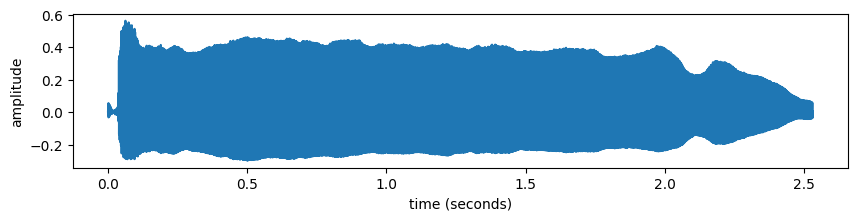

Reconstruction MSE: 0.046411


In [7]:
def quantize_subbands(Xf, target_bits=16):
    """Quantize each subband of the MDCT output to an integer of given number of bits."""

    X_quantized = np.zeros_like(Xf)
    for i in range(len(Xf[0,:])):
      # Scaling the signal to the range of [0, 2^target_bits - 1]
      scaled = (Xf[:,i] - np.min(Xf[:,i])) / (np.max(Xf[:,i]) - np.min(Xf[:,i])) * (2**target_bits - 1)
      # Quantize by rounding
      quantized = np.round(scaled)
      # Re-scaling back to the original amplitude range
      X_quantized[:,i] = (quantized / (2**target_bits - 1)) * (np.max(Xf[:,i]) - np.min(Xf[:,i])) + np.min(Xf[:,i])
    return X_quantized

def quantize_signal(x, target_bits):
  # Scaling the signal to the range of [0, 2^target_bits - 1]
  x_scaled = (x - np.min(x)) / (np.max(x) - np.min(x)) * (2**target_bits - 1)
  # Quantize by rounding
  x_quantized = np.round(x_scaled)
  # Re-scaling back to the original amplitude range
  x_output = (x_quantized / (2**target_bits - 1)) * (np.max(x) - np.min(x)) + np.min(x)
  return x_output


Xf = compute_mcdt(x, N, fs)

# Quantize the MDCT coefficients one band at a time
quantized_Xf = quantize_subbands(Xf, 7)

# Quantize the MDCT coefficients all together
# quantized_Xf = quantize_signal(Xf, 7)

# Reconstruct the time-domain signal from the MDCT coefficients
x_reconstructed = compute_inverse_mcdt(quantized_Xf, N)

# Quantize the original signal
# x_reconstructed = quantize_signal(x, 7)

# Plot the original and reconstructed signals
display_sound(x_reconstructed, fs)

# Evaluate the Reconstruction Quality
mse = np.mean((x[:len(x_reconstructed)] - x_reconstructed)**2)
print(f"Reconstruction MSE: {mse:.6f}")

**Questions:**

1. Quantize the MDCT output (floting point values) one band at a time, to integer values of different number of bits. Find the lowest number of bits for which you do not hear a difference. Explain the result. (Note: In the code given the quantized data is not stored as integer values, but you can evaluate the results as if it was)

2. Compare the quantization done one band at a time, with the quantization done for the whole MDCT output, with the one done on the original signal. Explain the result.

3. What is the best coding bit-rate obtained compared with the original signal. Explain the result.
---